Notebook to create a histogram of 4 selected regions against a fixed average of the total image and compare these results between the generated images and the real ones

our test is structured like this:

*   we choose 4 distinct geographical positions (4 pixels) such as Mont Blanc, the Sicilian coast, a point in the sea, Genoa;
*   we choose an average temperature value (e.g. 15 degrees) (maybe we repeat it for three different winter - average - summer values)
*   we generate 1000 images with that average value
*   let's take 100 images with a close average value in the training set
*   let's take 1000 images with close average value in the complete dataset
*   Let's visually compare the histograms for the 4 selected pixels: histogram of 100 training values, histogram of 1000 historical values ​​and histogram of 1000 generated ones

# IMPORT

In [1]:
!pip install earthkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.5/345.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9

In [2]:
!pip install cfgrib xarray matplotlib opencv-python

In [ ]:
from __future__ import print_function
import argparse
import os
import time
import random
import numpy
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.utils.data import DataLoader
from IPython.display import HTML
from torchvision import utils, datasets, transforms
import pandas as pd

from math import sqrt
from PIL import Image
import xarray as xr
import cfgrib
import matplotlib as cm
import cv2

from google.colab import files

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# FUNCTION FOR SIZE ADJUSTMENT

In [ ]:
# Funzione per espandere un'immagine (64x64 -> 128x128)
def expand_image(img):
    # Replica i pixel per raddoppiare le dimensioni
    return np.repeat(np.repeat(img, 2, axis=0), 2, axis=1)

# Funzione per ridurre un'immagine (128x128 -> 64x64)
def reduce_image(img):
    # Riduce la dimensione facendo la media di blocchi 2x2
    h, w = img.shape
    return img.reshape(h//2, 2, w//2, 2).mean(axis=(1, 3))

# IMPORT DATASET IF NOT SAVED

In [ ]:
#ds = cfgrib.open_datasets('/content/drive/MyDrive/DatiTesi/2012_2024.grib')
ds=xr.open_dataset('/content/drive/MyDrive/DatiTesi/2012_2024.grib',engine="cfgrib")

In [ ]:
dst2m=ds.t2m[:,:-1,:-1]
ds_trunc_t2m=ds.t2m[-12000:,:-1,:-1]  #DATASET RISTRETTO a 12000 img

In [ ]:
ds_C = (ds_trunc_t2m - 273)

In [ ]:
ds_norm = (ds_C + 50) / 100

# Scale to [0, 255]
ds_scaled = ds_norm * 255

NameError: name 'ds_C' is not defined

# TO SAVE

In [ ]:
ds_trunc_t2m.to_netcdf('/content/ds_trunc_2023_2024')
!cp -r '/content/ds_trunc_2023_2024' /content/drive/MyDrive/

In [ ]:
ds_C.to_netcdf('/content/ds_trunc_2023_2024_C')
!cp -r '/content/ds_trunc_2023_2024_C' /content/drive/MyDrive/

In [ ]:
ds_scaled.to_netcdf('/content/ds_trunc_2023_2024_scaled')
!cp -r '/content/ds_trunc_2023_2024_scaled' /content/drive/MyDrive/

In [ ]:
!unzip /content/drive/MyDrive/DatiTesi/2023-07-26H15-00_2024-12-07H14_00.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_11430.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_7324.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_6514.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_6940.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_4961.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_7074.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_10224.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_5123.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_8018.tiff  
  inflating: content/Dati/2023-07-26H15-00_2024-12-07H14_00/train/255data/image_11698.tiff  
  inflating: content/Dati/2

# IMPORT IF ALREDY SAVED

In [ ]:
cdf=xr.open_dataset("/content/drive/MyDrive/ds_trunc_2023_2024_scaled") #[0,255]

<ipython-input-5-1453a19f8b5a>:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  cdf=xr.open_dataset("/content/drive/MyDrive/ds_trunc_2023_2024_scaled") #[0,255]


# Generate Image

## COSTANTS

In [ ]:
# Set uncertainty analysis number
uncertainty_num = 1      # "Need Change"

image_size = 128
workers = 8
ngpu = 1
nz = 5
ngf = 64
nc = 1

means=(((np.array([8.76288321,19.57378313,27.60350246])+50)/100-0.5)/0.5).tolist()#inverno,medio,estate   (-1,1)
date=['2024-01-22','2023-10-15','2023-08-15']
n_generated_img=1000

date_size = len(means)	#Calculate the number of days.

#generated_imgs=torch.zeros(date_size, 128,128)

#MANUALLY IMPORTED MODELS

In [ ]:
#xlsx_path="/content"
model_path='/content/model_2023_2024_5-final.pt'
result_path="/content/results"
if not os.path.exists(result_path):
      os.makedirs(result_path)


#DRIVE STORED FINAL MODELS

In [ ]:
#xlsx_path="/content"
model_path='/content/drive/MyDrive/DatiTesi/TrainingCongiunto/final models/model_2023_2024_5-final.pt'
result_path="/content/results"
if not os.path.exists(result_path):
      os.makedirs(result_path)

#DRIVE STORED DIFFERENT EPOCHS MODELS

In [ ]:
#xlsx_path="/content"
model_path='/content/drive/MyDrive/DatiTesi/TrainingCongiunto/models_2023_2024_5/model-32.pt'
result_path="/content/results"
if not os.path.exists(result_path):
      os.makedirs(result_path)

# Model and Kernel Visualization

In [ ]:
# Model class must be defined somewhere
model = torch.load(model_path, weights_only=False)
type(model)
model_items=model.items()
model_dict=dict(model_items)
model_keys=model_dict.keys()
print(model_keys)
for i,key in enumerate(model_keys):
  print(f"{model_dict[key].shape}{key:>50}")




dict_keys(['image.0.weight', 'image.1.weight', 'image.1.bias', 'image.1.running_mean', 'image.1.running_var', 'image.1.num_batches_tracked', 'prior.0.weight', 'prior.1.weight', 'prior.1.bias', 'prior.1.running_mean', 'prior.1.running_var', 'prior.1.num_batches_tracked', 'main.0.weight', 'main.1.weight', 'main.1.bias', 'main.1.running_mean', 'main.1.running_var', 'main.1.num_batches_tracked', 'main.3.weight', 'main.4.weight', 'main.4.bias', 'main.4.running_mean', 'main.4.running_var', 'main.4.num_batches_tracked', 'main.6.weight', 'main.7.weight', 'main.7.bias', 'main.7.running_mean', 'main.7.running_var', 'main.7.num_batches_tracked', 'main.9.weight', 'main.10.weight', 'main.10.bias', 'main.10.running_mean', 'main.10.running_var', 'main.10.num_batches_tracked', 'main.12.weight'])
torch.Size([5, 512, 4, 4])                                    image.0.weight
torch.Size([512])                                    image.1.weight
torch.Size([512])                                      image.1.b

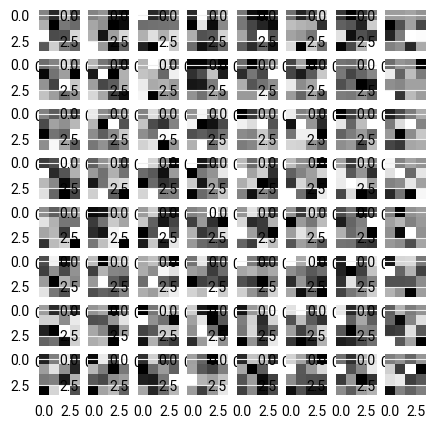

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(model_dict['main.9.weight'][64,i,:,:].cpu().numpy(),cmap='gray')

    #ax.tight_layout()
    #ax.show()
plt.show()

In [ ]:
for i, ax in enumerate(axs.flatten()):
  ax = axes.flatten()[i]
  plt.imshow(model_dict['main.9.weight'][64,i,:,:].cpu().numpy(),cmap='gray')
  plt.colorbar(cmap='gray')

plt.tight_layout()
plt.show()

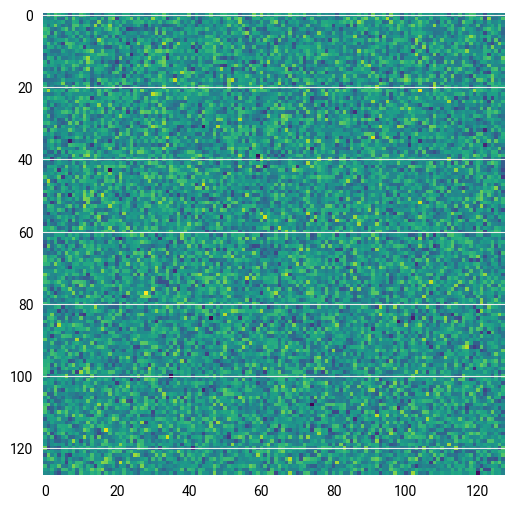

In [ ]:
plt.imshow(model_dict['main.6.weight'][128:,:,0,0].cpu().numpy())

In [ ]:
model_dict['main.6.weight'][128:,:,0,0].cpu().numpy().shape

(128, 128)

# NET FUNCTIONS

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # input is nz, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
        )
        self.prior = nn.Sequential(
            # state size. 1 x 1 x 1
            nn.ConvTranspose2d(1, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
            # state size. (ngf*8) x 4 x 4
        )
        self.main = nn.Sequential(
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, image, prior):
        image = self.image(image)
        prior = self.prior(prior)
        #Stitch two tensors (image, prior) together, dim=1 means splicing according to dimension 1 (column), side by side
        incat = torch.cat((image, prior), dim=1)
        return self.main(incat)

def tensor_to_np(tensor):
  img = tensor.cpu().clone()
  #img = img.cpu().numpy().squeeze(0).transpose((1, 2, 0))
  img = img.numpy().transpose((1, 2, 0))
  unloader = transforms.ToPILImage()
  img = unloader(img)
  #print(img)
  return img

def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device to run on is", device)

############################
# Read the Condition Number
############################
valid_label = []                              #Condition Number Tensor (daynum*1*1*1)  future days/1 dimension/1*1 pix
print("date_size is", date_size)
valid_label_ones = torch.ones(date_size, 1, 1, 1).to(device)
for m in range(date_size):
    mean_folder_path=result_path+'/'+date[m]
    if not os.path.exists(mean_folder_path):
      os.makedirs(mean_folder_path)
    valid_label_ones[m]=valid_label_ones[m]* means[m]
valid_label = valid_label_ones.to(device)
print("The tensor of condition number have been created.")

device to run on is cuda:0
date_size is 3
The tensor of condition number have been created.


# NETS VISUALIZATION

In [ ]:
for name, layer in model.named_modules():
  print(model.named_modules())

<generator object Module.named_modules at 0x7a22e7da1250>
<generator object Module.named_modules at 0x7a2309fd3450>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a2309fd3450>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a2309fd3450>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator object Module.named_modules at 0x7a22de938e10>
<generator obj

In [ ]:
layer.register_forward_hook(hook_fn)

In [ ]:
model=Generator(0)

In [ ]:
model_image_g

ConvTranspose2d(5, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)

In [ ]:
model_image_g=model.image[0]
model_image_g(torch.randn(1,5,1,1)).shape

torch.Size([1, 512, 4, 4])

In [ ]:
def hook_fn(module, input, output):
    print(f"Layer: {module}, Output shape: {output.shape}")

for name, layer in model.named_modules():
    layer.register_forward_hook(hook_fn)

# Forward pass
model

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(5, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (prior): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [ ]:
def visualize_feature_maps(model, input_image):
    layers = [model.conv1, model.conv2, model.conv3]
    for layer in layers:
        input_image = layer(input_image)
        plt.figure(figsize=(10, 10))
        for i in range(input_image.shape[1]):
            plt.subplot(8, 8, i+1)
            plt.imshow(input_image[0, i].detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

In [ ]:
model=Generator(0)

In [ ]:
netG = Generator(0).to(device)
netG.load_state_dict(torch.load(model_path, map_location=device))
netG.eval()
noise_valid = torch.randn(1, nz, 1, 1, device=device)

valid_label_j = torch.zeros(1, 1, 1, 1, device=device)
valid_label_j[0] = valid_label[0]
model=netG(noise_valid, valid_label_j)

<ipython-input-16-752bf1da6c55>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
visualize_feature_maps(model)

NameError: name 'visualize_feature_maps' is not defined

# Generation

In [ ]:
generated_imgs =xr.DataArray(np.zeros((date_size,64,64,n_generated_img)), dims=["mean2mt","lat", "lon","sample"], coords={'mean2mt': means,'lat': cdf.latitude.values[:],'lon': cdf.longitude.values[:], "sample": np.arange(n_generated_img)})

#downscaled_std = torch.zeros(date_size,image_size,image_size)

validation_list = torch.zeros(date_size,uncertainty_num,image_size,image_size)

# Load trained model
netG = Generator(0).to(device)
netG.load_state_dict(torch.load(model_path, map_location=device))
netG.eval()

stat_time = float(time.time())

with open('out.txt', 'w') as output:

  for d in range(date_size):   # calculating fixing the mean
    print("Generating imgs for date "+ date[d])
    downscaled_result = torch.zeros(n_generated_img,image_size,image_size)
    #print("Begin downscaled data:", d)
    for k in range(n_generated_img):
      print(str(k)+'...' if k!=n_generated_img-1 else str(k)+' ...\n', end='')
      downscaled_list = torch.zeros(uncertainty_num,image_size,image_size)  #For each day, a scratchpad for the calculation results of multiple iterations
      for i in range(uncertainty_num):

        #manualSeed = 1 + i
        #print("Random Seed: ", manualSeed)

        #random.seed(manualSeed)
        #torch.manual_seed(manualSeed)
        #torch.cuda.manual_seed(manualSeed)

        # torch.manual_seed(torch.randint(0, manualSeed, (1,)).item())
        #torch.cuda.manual_seed(torch.randint(0, manualSeed, (1,)).item())



        #For the same manualSeed, the numbers randomly generated by torch.rand in this code sequence are fixed in this program (note: the numbers are different if you write the same sentence again)
        noise_valid = torch.randn(1, nz, 1, 1, device=device)  #[num, channel, height, width]   Each seed number iteratively samples a 10*1*1 noise

        output.write(f"Noise for sample {k}, iteration {i}:\n"+str(noise_valid))

        #netG = Generator(0).to(device)
        #netG.load_state_dict(torch.load('model-final.pt', map_location=device))
        #netG.eval()
        # Generate the Fake Images
        valid_label_j = torch.zeros(1, 1, 1, 1, device=device)
        valid_label_j[0] = valid_label[d]    #Make the condition numbers into a 4-dimensional Tensor
        with torch.no_grad():
            validation = netG(noise_valid, valid_label_j).detach().cpu()    #Here, we cannot make all the days into one tensor, because this will cause a huge network leanding to GPU out of memory
            #validation_list[d][i]=validation
        downscaled_list[i] = (validation[0][0]*0.5+0.5)*255 #[-1,1] to 0-255
        downscaled_result[k] = (downscaled_list[i]/uncertainty_num) if i == 0 else downscaled_result[k] + (downscaled_list[i]/uncertainty_num)


        #downscaled_output_single = torch.zeros(1,image_size,image_size)
        #downscaled_output_single[0] = downscaled_result[d]
        #image_single = tensor_to_np(downscaled_output_single)

        #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE
        #image_single.save(r"C:\Users\fedeb\OneDrive\Desktop\Supplementary Material\ProvaDownscaling\results//"+ date[d]+'_'+str(i)+'_'+ "_result.tif")
        #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE


      downscaled_output = torch.zeros(1,image_size,image_size)
      downscaled_output1 = torch.zeros(1,image_size,image_size)
      downscaled_output[0] = downscaled_result[k]
      image = downscaled_output.numpy()
      #print("Finish result data:", d)
      #image.save(result_path+'/'+ date[d] + "_result.tif")
      im = Image.fromarray(image[0])

      #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE
      im.save(result_path+'/'+ date[d]+ '/'+str(k)+ "_result.tif")
      #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE

      #print("Finish result data:", d)
      #image.save(result_path+'/'+ date[d][:date[d].rfind(".tiff")] + "_result.tif")  # "Need Change" Please change "results//" here to the folder name you want to store the outputs.


      generated_imgs[d,:,:,k]=reduce_image(image[0])

      #Calculation uncertainty
      #for i in range(uncertainty_num):
      #  downscaled_std[d] = downscaled_std[d] + (downscaled_list[i] - downscaled_result[d])*(downscaled_list[i] - downscaled_result[d])
      #downscaled_std[d] = numpy.sqrt(downscaled_std[d])/uncertainty_num
      #downscaled_output1[0] = downscaled_std[d]
      #uncertainty = tensor_to_np(downscaled_output1)
      #print("Finish uncertainty data:", d)

      #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE
      #uncertainty.save(result_path+'/'+ date[d]+ '/'+str(k)+ "_uncertainty.tif")  # "Need Change" Please change "results//" here to the folder name you want to store the outputs.
      #SAVING HERE##################SAVING HERE###################SAVING HERE################SAVING HERE###########SAVING HERE###################SAVING HERE###########SAVING HERE

      if (d + 1) % 365 == 0:
        end_time = float(time.time())
        print("Finish data:",date[d])
        print("Used time:",(end_time-stat_time)/60,"min | Estimate left time:",(end_time-stat_time)/(d + 1)*(date_size-d-1)/3600,"hours")
    print("Successful finished!")

<ipython-input-11-7dd688aede6d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(model_path, map_location=device))


Generating imgs for date 2024-01-22
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...

# Save generated_imgs with FINAL MODEL

In [ ]:
generated_imgs.to_netcdf(f'/content/generated_imgs_2023-2024_5_64x64_0-255_n{n_generated_img}_uncertainty{uncertainty_num}')
!cp -r 'generated_imgs_2023-2024_5_128x128_0-255_n1000_uncertainty1' /content/drive/MyDrive/

# Save generated_imgs with DIFFERENT MODEL

In [ ]:
generated_imgs.to_netcdf(f'/content/generated_imgs_2023-2024_5_EPOCH{"".join(filter(str.isdigit, os.path.basename(model_path)))}_64x64_0-255_n{n_generated_img}_uncertainty{uncertainty_num}')
!cp -r 'generated_imgs_2023-2024_5_EPOCH32_64x64_0-255_n1000_uncertainty1' /content/drive/MyDrive/

# LOAD GENERATED IMGS

In [ ]:
generated_imgs = xr.open_dataset(f'/content/drive/MyDrive/generated_imgs_2023-2024_5_EPOCH32_64x64_0-255_n1000_uncertainty1')
generated_imgs=generated_imgs.rename_vars({'__xarray_dataarray_variable__':'t2m'})
generated_imgs=generated_imgs.t2m

In [ ]:
generated_imgs

<xarray.DataArray 't2m' (mean2mt: 3, lat: 64, lon: 64, sample: 1000)> Size: 98MB
[12288000 values with dtype=float64]
Coordinates:
  * mean2mt  (mean2mt) float64 24B 0.1753 0.3915 0.5521
  * lat      (lat) float64 512B 50.0 49.75 49.5 49.25 ... 35.0 34.75 34.5 34.25
  * lon      (lon) float64 512B 5.0 5.25 5.5 5.75 6.0 ... 20.0 20.25 20.5 20.75
  * sample   (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [ ]:
bin_edges

array([ 4.24316406,  5.13759778,  6.03203149,  6.9264652 ,  7.82089892,
        8.71533263,  9.60976634, 10.50420006, 11.39863377, 12.29306748,
       13.1875012 , 14.08193491, 14.97636862, 15.87080234, 16.76523605,
       17.65966976, 18.55410348, 19.44853719, 20.3429709 , 21.23740462,
       22.13183833])

In [ ]:
cdf

<xarray.Dataset> Size: 197MB
Dimensions:     (time: 12000, latitude: 64, longitude: 64)
Coordinates:
  * time        (time) datetime64[ns] 96kB 2023-07-26T15:00:00 ... 2024-12-07...
    valid_time  (time) datetime64[ns] 96kB ...
  * latitude    (latitude) float64 512B 50.0 49.75 49.5 ... 34.75 34.5 34.25
  * longitude   (longitude) float64 512B 5.0 5.25 5.5 5.75 ... 20.25 20.5 20.75
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
Data variables:
    t2m         (time, latitude, longitude) float32 197MB ...

In [ ]:
print(f'[{gen_data_pos_values.min()/ 255 * 100 - 50}, {gen_data_pos_values.max()/ 255 * 100 - 50}]')

[13.728589824601713, 26.012046664368867]


In [ ]:
gen_values = gen_data_pos_values[i] / 255 * 100 - 50

In [ ]:
{'Rome': (32, 30),
 'Milan': (18, 17),
 'Naples': (37, 37),
 'Turin': (20, 11),
 'Palermo': (48, 33),
 'Genoa': (22, 16),
 'Bologna': (22, 25),
 'Florence': (25, 25),
 'Bari': (36, 47),
 'Catania': (50, 40),
 'Venice': (18, 29),
 'Verona': (18, 24),
 'Sassari': (37, 14),
 'Cagliari': (43, 16),
 'Monte Bianco': (17, 7)}

{'Rome': (32, 30),
 'Milan': (18, 17),
 'Naples': (37, 37),
 'Turin': (20, 11),
 'Palermo': (48, 33),
 'Genoa': (22, 16),
 'Bologna': (22, 25),
 'Florence': (25, 25),
 'Bari': (36, 47),
 'Catania': (50, 40),
 'Venice': (18, 29),
 'Verona': (18, 24),
 'Sassari': (37, 14),
 'Cagliari': (43, 16),
 'Monte Bianco': (17, 7)}

In [ ]:
positions

[(32, 30),
 (37, 37),
 (48, 33),
 (22, 16),
 (25, 25),
 (36, 47),
 (18, 29),
 (37, 14),
 (40, 23),
 (17, 7)]

# Select Region and t2m mean

In [ ]:
# Aggiunta dei nomi delle principali città italiane
cities = {
    "Rome": (12.4964, 41.9028),
    #"Milan": (9.1900, 45.4642),
    "Naples": (14.2681, 40.8522),
    #"Turin": (7.6869, 45.0703),
    "Palermo": (13.3615, 38.1157),
    "Genoa": (8.9463, 44.4056),
    #"Bologna": (11.3426, 44.4949),
    "Florence": (11.2558, 43.7696),
    "Bari": (16.8524, 41.1171),
    #"Catania": (15.0873, 37.5023),
    "Venice": (12.3155, 45.4408),
    "Sassari": (8.5600, 40.7272),
    #"Cagliari": (9.1192, 39.2238),
    "Sea Point": (10.8,40),
    "Monte Bianco": (6.8651, 45.8326)
}

# Calcolo degli indici per tutte le città
positions = {}
lat_start, lat_end, lat_step = 50.0, 34.25, -0.25  # Latitudine decresce
lon_start, lon_end, lon_step = 5.0, 20.75, 0.25

for name, (lon, lat) in cities.items():
    lat_index = (lat_start - lat) / abs(lat_step)
    lon_index = (lon - lon_start) / lon_step
    positions[name] = (int(round(lat_index)), int(round(lon_index)))
positions=list(positions.values())
# Definizione delle località
locations = list(cities.keys())

string_date_mean=[pd.Timestamp('2024-01-22T12:00:00.000000000').strftime('%Y-%m-%d %H:%M'),
                  pd.Timestamp('2023-10-15T12:00:00.000000000').strftime('%Y-%m-%d %H:%M'),
                  pd.Timestamp('2023-08-15T12:00:00.000000000').strftime('%Y-%m-%d %H:%M')]

In [ ]:
pd.Timestamp('2024-01-22T12:00:00.000000000').strftime('%Y-%m-%d %H:%M')

'2024-01-22 12:00'

##View MEAN t2m of 3 selected days:

*   2024-01-22T12:00
*   2023-08-15T12:00
*   2023-10-15T12:00






In [ ]:
np.mean(cdf.t2m.loc['2024-01-22T12:00:00.000000000'])*100/255-50 #°C

<xarray.DataArray 't2m' ()> Size: 8B
array(8.76288321)
Coordinates:
    time        datetime64[ns] 8B 2024-01-22T12:00:00
    valid_time  datetime64[ns] 8B ...
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...

In [ ]:
np.mean(cdf.t2m.loc['2023-08-15T12:00:00.000000000'])*100/255-50#°C

<xarray.DataArray 't2m' ()> Size: 8B
array(27.60350246)
Coordinates:
    time        datetime64[ns] 8B 2023-08-15T12:00:00
    valid_time  datetime64[ns] 8B ...
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...

In [ ]:
np.mean(cdf.t2m.loc['2023-10-15T12:00:00.000000000'])*100/255-50#°C

<xarray.DataArray 't2m' ()> Size: 8B
array(19.57378313)
Coordinates:
    time        datetime64[ns] 8B 2023-10-15T12:00:00
    valid_time  datetime64[ns] 8B ...
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...

# VIOLINS and Histogram

In [ ]:
cdf_train_means = cdf.t2m[-9000:].mean(dim=["latitude", "longitude"])
cdf_total_means = cdf.t2m.mean(dim=["latitude", "longitude"])
generated_means = np.zeros((date_size, n_generated_img))

cdf_no_date_var = cdf.copy()
del cdf_no_date_var['time']

pos_train_values = np.zeros((len(locations), 100))
pos_total_values = np.zeros((len(locations), 1000))
gen_data_pos_values = np.zeros((len(locations), n_generated_img))



for d in range(date_size):
    print("Violin plot for mean " + str(means[d]))

    target_mean = means[d]

    dist_train = abs(cdf_train_means - (target_mean * 0.5 + 0.5) * 255)
    dist_total = abs(cdf_total_means - (target_mean * 0.5 + 0.5) * 255)

    sorted_indices_train = dist_train.argsort(axis=0)[:100]
    sorted_indices_total = dist_total.argsort(axis=0)[:1000]

    fig, axs = plt.subplots(5,4, figsize=(40, 60), facecolor='w', edgecolor='k')
    fig.suptitle(f"Mean {('%.3f'%(means[d]*50))}°C")  # in °C
    #fig.subplots_adjust(hspace = .5, wspace=.001)

    j=1
    for i, loc in enumerate(locations):
        print("Location: " + locations[i])

        pos_train_values[i] = cdf_no_date_var.t2m[-9000:].isel(time=sorted_indices_train)[:, positions[i][0], positions[i][1]].to_numpy()
        pos_total_values[i] = cdf_no_date_var.isel(time=sorted_indices_total).t2m[:, positions[i][0], positions[i][1]].to_numpy()
        gen_data_pos_values[i] = generated_imgs.isel(mean2mt=d).isel(lat=positions[i][0], lon=positions[i][1]).to_numpy()

        train_values = pos_train_values[i] / 255 * 100 - 50
        total_values = pos_total_values[i] / 255 * 100 - 50
        gen_values = gen_data_pos_values[i] / 255 * 100 - 50

        # Creiamo gli istogrammi normalizzati
        #bins = np.histogram_bin_edges(train_values, bins=40)
        # Numero di bin
        n_bins=40
        hist_train, bin_edges_train = np.histogram(train_values, bins=n_bins, density=False)
        hist_total, bin_edges_total = np.histogram(total_values, bins=n_bins, density=False)
        hist_gen, bin_edges_gen = np.histogram(gen_values, bins=n_bins, density=False)

        # Normalizziamo per avere la somma delle frequenze pari a 1
        # Evitiamo la divisione per zero
        hist_train = hist_train / hist_train.sum()
        hist_total = hist_total / hist_total.sum()
        hist_gen = hist_gen / hist_gen.sum()
        # Plottiamo gli istogrammi

        plt.subplot(5,4,j)
        plt.bar(bin_edges_train[:-1], hist_train, width=np.diff(bin_edges_train), alpha=0.5, label="Training (100)", align="edge")
        #plt.title(f"Histogram for {loc} mean {(means[d]*50)}°C")  # in °C
        #plt.xlabel("Temperature (°C)")
        #plt.ylabel("Normalized Frequency")
        #plt.legend()
        #plt.tight_layout()
        #plt.show()
        plt.bar(bin_edges_total[:-1], hist_total, width=np.diff(bin_edges_total), alpha=0.5, label="Historical (1000)", align="edge")
        #plt.title(f"Histogram for {loc} mean {(means[d]*50)}°C")  # in °C
        #plt.xlabel("Temperature (°C)")
        #plt.ylabel("Normalized Frequency")
        #plt.legend()
        #plt.tight_layout()
        #plt.show()
        plt.bar(bin_edges_gen[:-1], hist_gen, width=np.diff(bin_edges_gen), alpha=0.5, label=f"Generated ({n_generated_img})", align="edge")

        plt.title(f"Histogram for {loc} mean {('%.3f'%(means[d]*50))}°C")  # in °C
        plt.xlabel("Temperature (°C)")
        plt.ylabel("Normalized Frequency")
        plt.legend()
        plt.tight_layout()

        #plt.show()


        # Creazione del violin plot
        data = [train_values, total_values, gen_values]
        labels = ["Training (100)", "Historical (1000)", f"Generated ({n_generated_img})"]

        plt.subplot(5,4,j+1)
        j+=2
        plt.violinplot(data, showmeans=True, showmedians=True)
        plt.xticks([1, 2, 3], labels)
        plt.title(f"Violin Plot for {loc} - Mean {('%.3f'%(means[d]*50))}°C")
        plt.ylabel("Temperature (°C)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Supponiamo che le variabili cdf, generated_imgs, locations, positions, means, etc. siano già definite

cdf_train_means = cdf.t2m[-9000:].mean(dim=["latitude", "longitude"])
cdf_total_means = cdf.t2m.mean(dim=["latitude", "longitude"])

generated_means = np.zeros((date_size, n_generated_img))

cdf_no_date_var = cdf.copy()
del cdf_no_date_var['time']

pos_train_values = np.zeros((len(locations), 100))
pos_total_values = np.zeros((len(locations), 1000))
gen_data_pos_values = np.zeros((len(locations), n_generated_img))

for d in range(date_size):
    target_mean = means[d]
    dist_train = abs(cdf_train_means - (target_mean * 0.5 + 0.5) * 255)
    dist_total = abs(cdf_total_means - (target_mean * 0.5 + 0.5) * 255)
    sorted_indices_train = dist_train.argsort(axis=0)[:100]
    sorted_indices_total = dist_total.argsort(axis=0)[:1000]

    for i, loc in enumerate(locations):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), facecolor='w', edgecolor='k')
        fig.suptitle(f"{loc} - Mean {('%.3f' % (means[d] * 50))}°C", fontsize=16)

        pos_train_values[i] = cdf_no_date_var.t2m[-9000:].isel(time=sorted_indices_train)[:, positions[i][0], positions[i][1]].to_numpy()
        pos_total_values[i] = cdf_no_date_var.isel(time=sorted_indices_total).t2m[:, positions[i][0], positions[i][1]].to_numpy()
        gen_data_pos_values[i] = generated_imgs.isel(mean2mt=d).isel(lat=positions[i][0], lon=positions[i][1]).to_numpy()

        train_values = pos_train_values[i] / 255 * 100 - 50
        total_values = pos_total_values[i] / 255 * 100 - 50
        gen_values = gen_data_pos_values[i] / 255 * 100 - 50

        # Creazione dell'istogramma
        n_bins = 40
        hist_train, bin_edges_train = np.histogram(train_values, bins=n_bins, density=True)
        hist_total, bin_edges_total = np.histogram(total_values, bins=n_bins, density=True)
        hist_gen, bin_edges_gen = np.histogram(gen_values, bins=n_bins, density=True)

        axs[0].bar(bin_edges_train[:-1], hist_train, width=np.diff(bin_edges_train), alpha=0.5, label="Training (100)", align="edge")
        axs[0].bar(bin_edges_total[:-1], hist_total, width=np.diff(bin_edges_total), alpha=0.5, label="Historical (1000)", align="edge")
        axs[0].bar(bin_edges_gen[:-1], hist_gen, width=np.diff(bin_edges_gen), alpha=0.5, label=f"Generated ({n_generated_img})", align="edge")
        axs[0].set_title("Histogram")
        axs[0].set_xlabel("Temperature (°C)")
        axs[0].set_ylabel("Normalized Frequency")
        axs[0].legend()
        axs[0].grid(axis='y', linestyle='--', alpha=0.7)

        # Creazione del violin plot
        data = [train_values, total_values, gen_values]
        labels = ["Training (100)", "Historical (1000)", f"Generated ({n_generated_img})"]
        axs[1].violinplot(data, showmeans=True, showmedians=True)
        axs[1].set_xticks([1, 2, 3])
        axs[1].set_xticklabels(labels)
        axs[1].set_title("Violin Plot")
        axs[1].set_ylabel("Temperature (°C)")
        axs[1].grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"plots/{loc}_mean_{d}.png")
        plt.close(fig)


In [ ]:
!zip -r /content/plot.zip /content/plots
files.download("/content/plot.zip")

  adding: content/plots/ (stored 0%)
  adding: content/plots/Monte Bianco_mean_1.png (deflated 10%)
  adding: content/plots/Palermo_mean_2.png (deflated 10%)
  adding: content/plots/Palermo_mean_1.png (deflated 10%)
  adding: content/plots/Sea Point_mean_0.png (deflated 9%)
  adding: content/plots/Bari_mean_1.png (deflated 10%)
  adding: content/plots/Florence_mean_0.png (deflated 10%)
  adding: content/plots/Sassari_mean_1.png (deflated 10%)
  adding: content/plots/Palermo_mean_0.png (deflated 9%)
  adding: content/plots/Sassari_mean_2.png (deflated 10%)
  adding: content/plots/Genoa_mean_1.png (deflated 10%)
  adding: content/plots/Venice_mean_1.png (deflated 9%)
  adding: content/plots/Naples_mean_0.png (deflated 9%)
  adding: content/plots/Rome_mean_1.png (deflated 10%)
  adding: content/plots/Rome_mean_2.png (deflated 10%)
  adding: content/plots/Sea Point_mean_1.png (deflated 9%)
  adding: content/plots/Florence_mean_2.png (deflated 10%)
  adding: content/plots/Venice_mean_0.png 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Italy plot

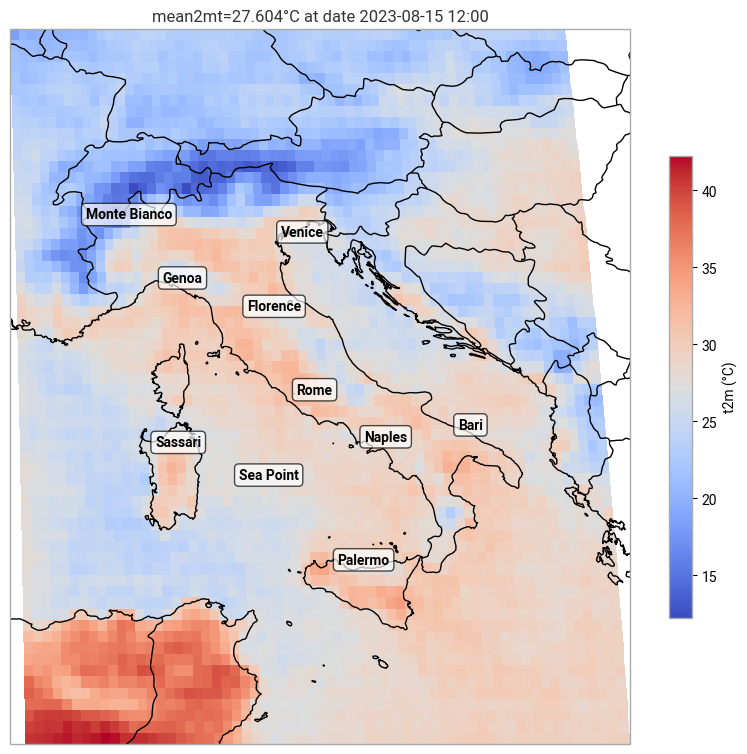

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Assumendo che img_to_plot sia già definito come nel tuo codice precedente
img_to_plot=(generated_imgs.isel(mean2mt=d)[:,:,100]/255*100-50)

fig = plt.figure(figsize=(10, 10))

# Creazione dell'asse con proiezione Robinson
ax = plt.axes(projection=ccrs.Robinson())

# Aggiunta delle coste e dei confini
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')

# Plot della differenza di temperatura
plot = img_to_plot.plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(),
    cbar_kwargs={"shrink": 0.6, "label": "t2m (°C)"}
)



for city, (lon, lat) in cities.items():
    ax.text(lon, lat, city, transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

# Titolo della mappa
plt.title(f"mean2mt={'%.3f'%((img_to_plot.mean2mt.values*0.5+0.5)*100-50)}°C at date {string_date_mean[d]}")

# Mostra la mappa
plt.show()


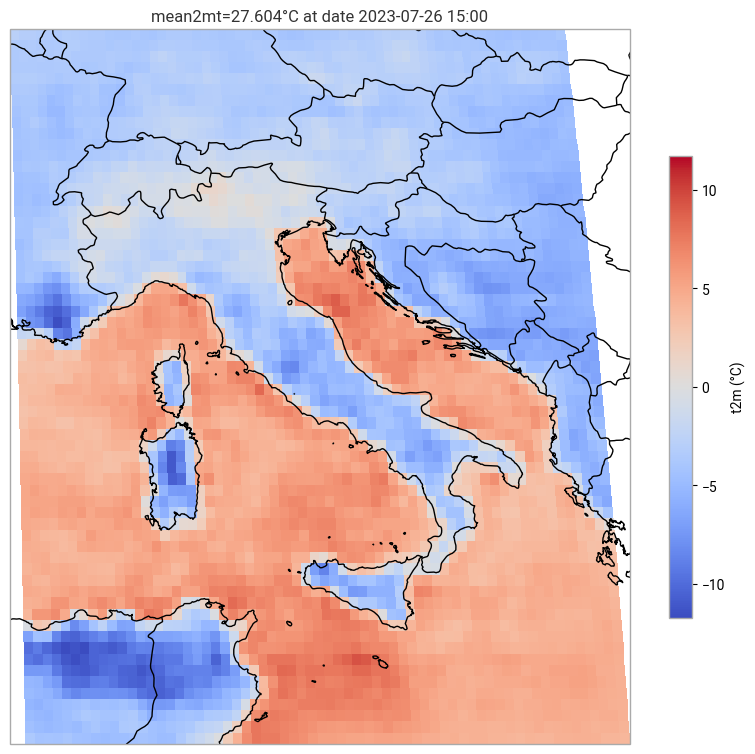

In [ ]:
img_to_plot=(generated_imgs.isel(mean2mt=d)[:,:,100]/255*100-50)-(generated_imgs.isel(mean2mt=d)[:,:,326]/255*100-50)  #IMG DIFFERENCE TO COMPARE

# Assuming img0 is your xarray data object
fig = plt.figure(figsize=(10, 10))

# Create an axis with a Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# Add coastlines
ax.coastlines(resolution="10m")

# Add the shapefile for Italy's boundaries
# This loads the 'admin_0_boundary' feature (which includes country boundaries)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')

# You can zoom in further on Italy's boundaries if needed
#ax.set_extent([-15, 45, 35, 50], crs=ccrs.PlateCarree())  # Adjust lat/lon to zoom in on Italy

# Plot the temperature data
plot = (img_to_plot).plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6,"label": "t2m (°C)"}
)

# Add a title with the time information
plt.title(f"mean2mt={'%.3f'%((img_to_plot.mean2mt.values*0.5+0.5)*100-50)}°C at date {pd.Timestamp(cdf.t2m[0].time.values).strftime('%Y-%m-%d %H:%M')}")

# Show the plot
plt.show()


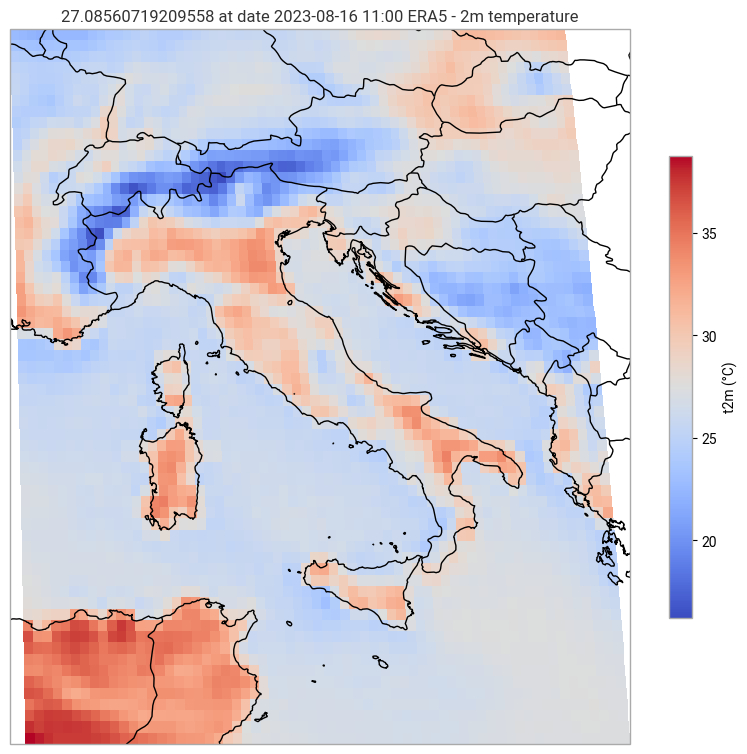

In [ ]:
index=500


# Assuming img0 is your xarray data object
fig = plt.figure(figsize=(10, 10))

# Create an axis with a Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# Add coastlines
ax.coastlines(resolution="10m")

# Add the shapefile for Italy's boundaries
# This loads the 'admin_0_boundary' feature (which includes country boundaries)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')

# You can zoom in further on Italy's boundaries if needed
#ax.set_extent([-15, 45, 35, 50], crs=ccrs.PlateCarree())  # Adjust lat/lon to zoom in on Italy

# Plot the temperature data
plot = (cdf.t2m[index]/255*100-50).plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6,"label": "t2m (°C)"}
)


# Add a title with the time information
plt.title(f"{cdf.t2m[index].mean().values/255*100-50} at date {pd.Timestamp(cdf.t2m[index].time.values).strftime('%Y-%m-%d %H:%M')} ERA5 - 2m temperature")

# Show the plot
plt.show()


# Italy Plot for 10 generated imgs for every mean

In [ ]:
img_to_plot[:,:,0]

<xarray.DataArray 't2m' (lat: 64, lon: 64)> Size: 33kB
array([[ 5.88651769,  5.56061389,  4.65159697, ...,  3.09107762,
         2.44764141,  3.31156413],
       [ 5.12887992,  5.13578527,  4.70956241, ...,  2.17017679,
         2.10512647,  1.96095785],
       [ 5.60760498,  5.61902813,  5.20988913, ...,  1.46241431,
         1.09744801,  0.84510354],
       ...,
       [13.26737348, 13.30459296, 13.74967687, ..., 18.7979485 ,
        18.66930793, 18.34528904],
       [14.10374062, 14.15009742, 14.47552251, ..., 18.1628418 ,
        17.66070198, 17.22639495],
       [14.68837364, 15.45156441, 16.57623889, ..., 19.61517932,
        19.07865636, 18.46805946]])
Coordinates:
    sample   int32 4B 0
  * lat      (lat) float64 512B 50.0 49.75 49.5 49.25 ... 35.0 34.75 34.5 34.25
  * lon      (lon) float64 512B 5.0 5.25 5.5 5.75 6.0 ... 20.0 20.25 20.5 20.75
    mean2mt  float64 8B 0.1753

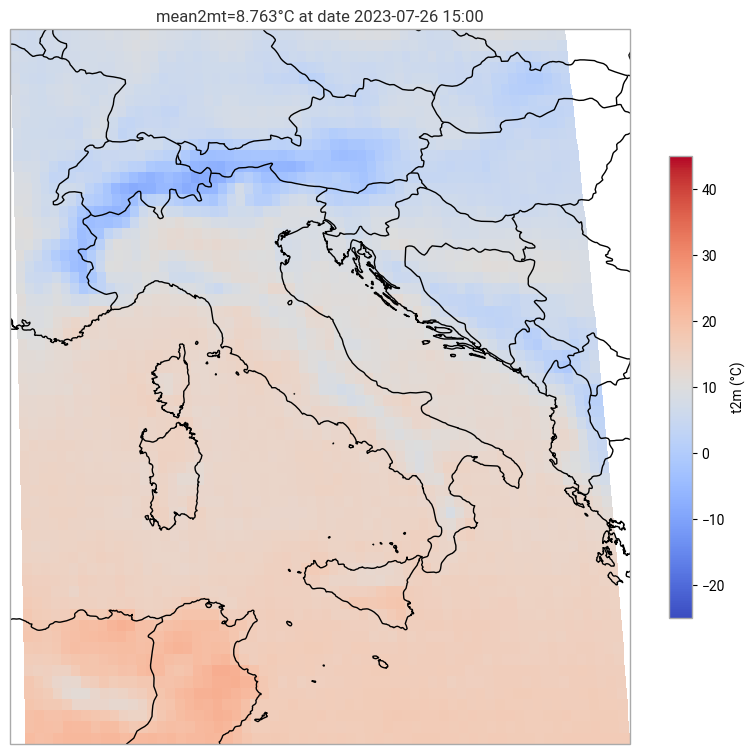

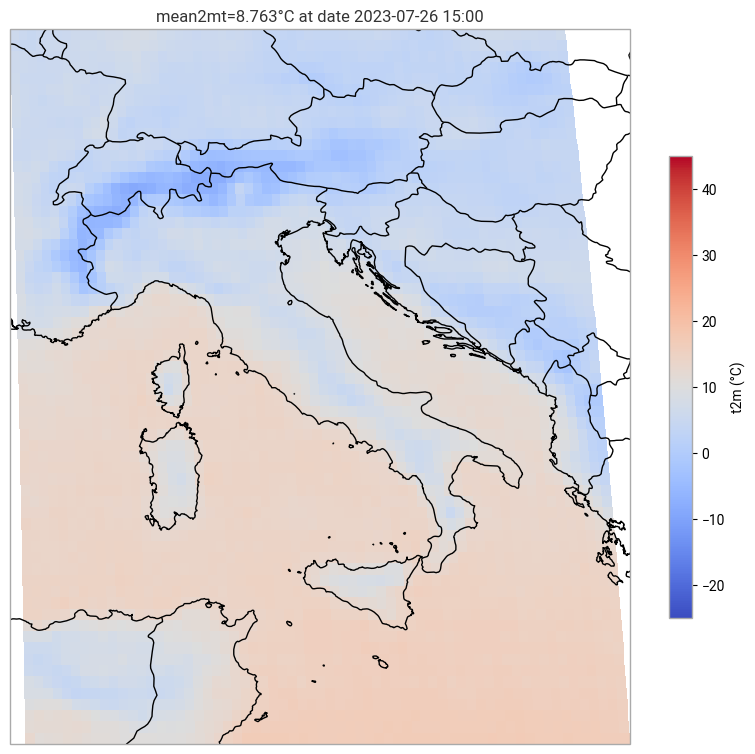

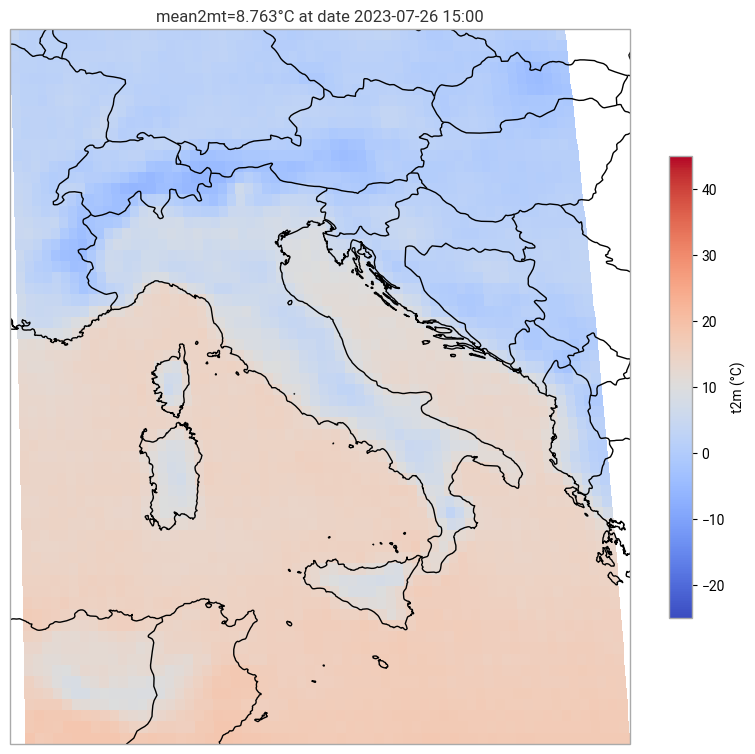

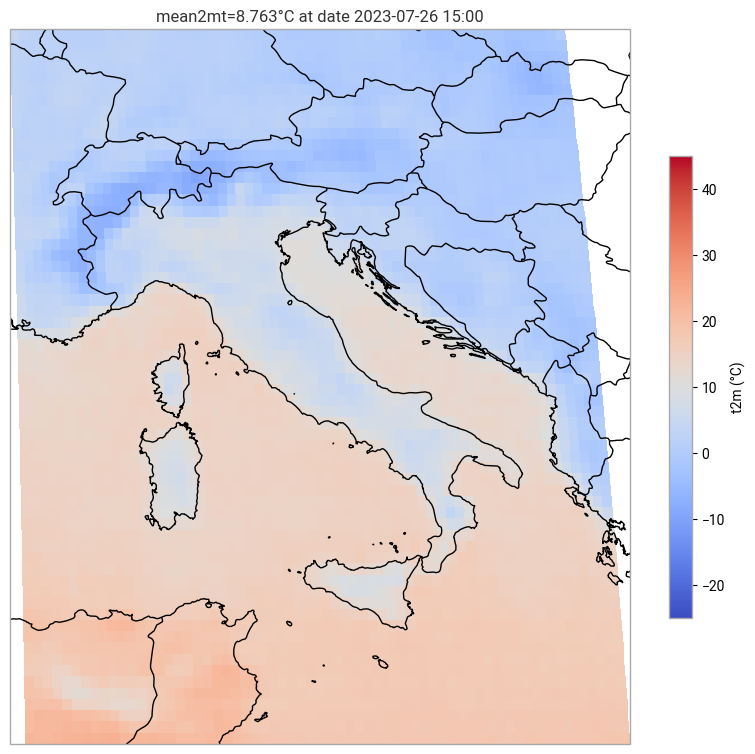

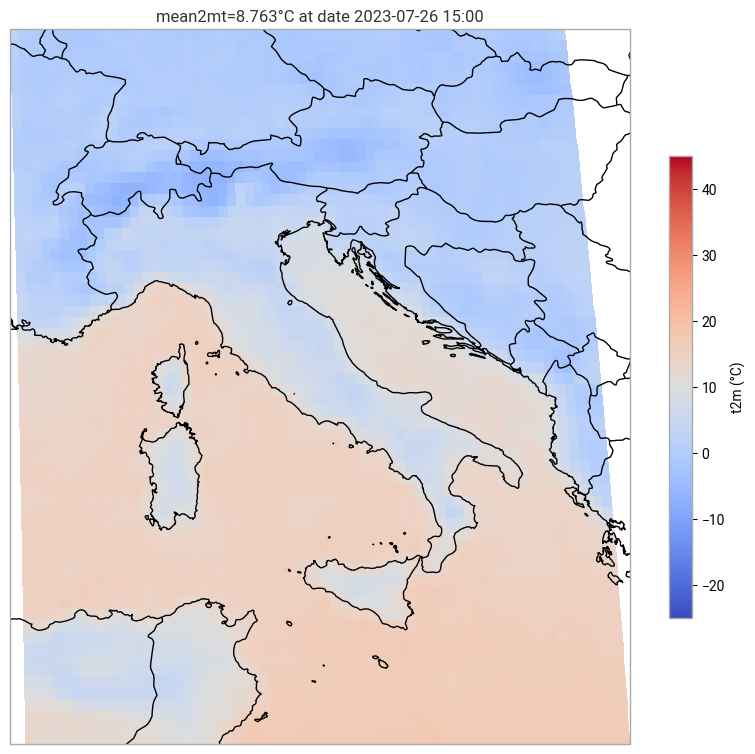

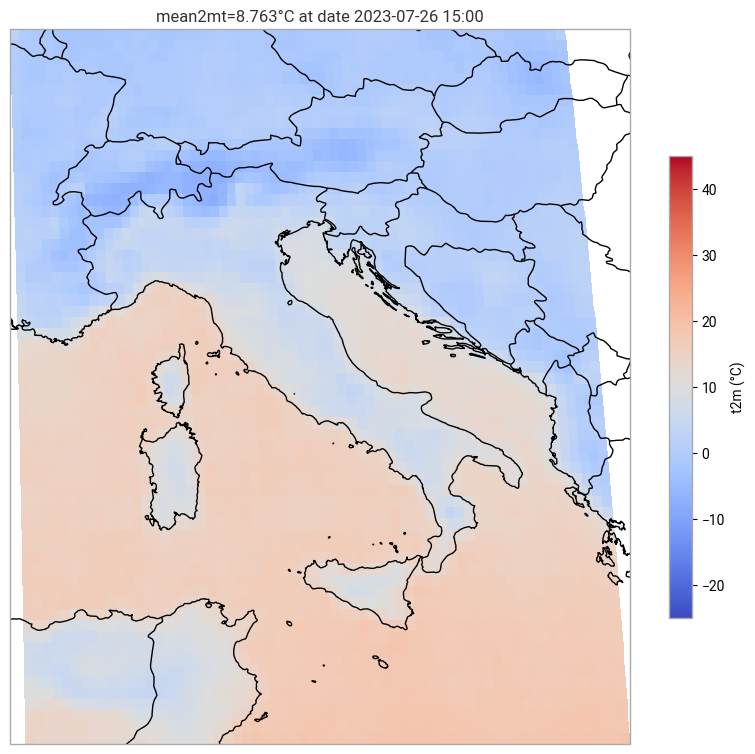

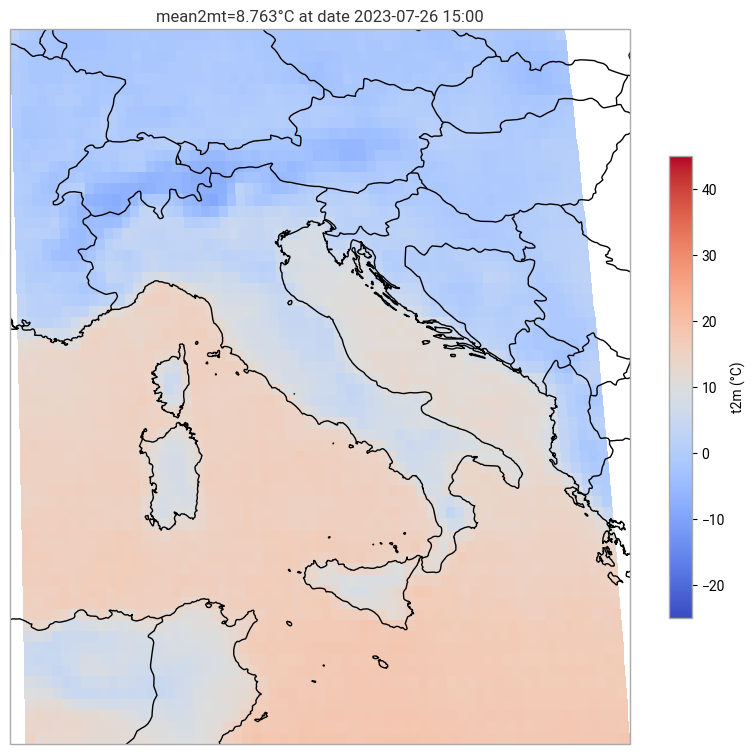

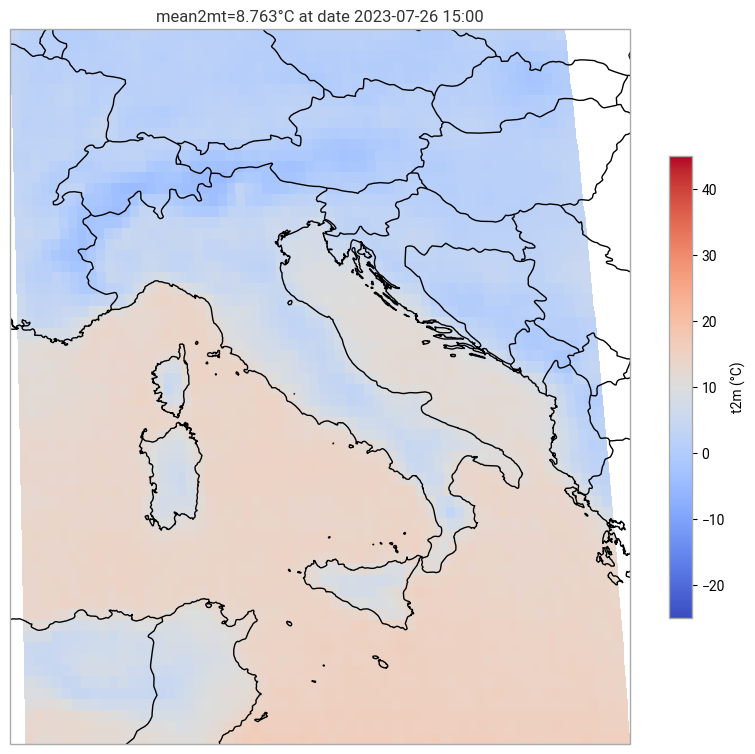

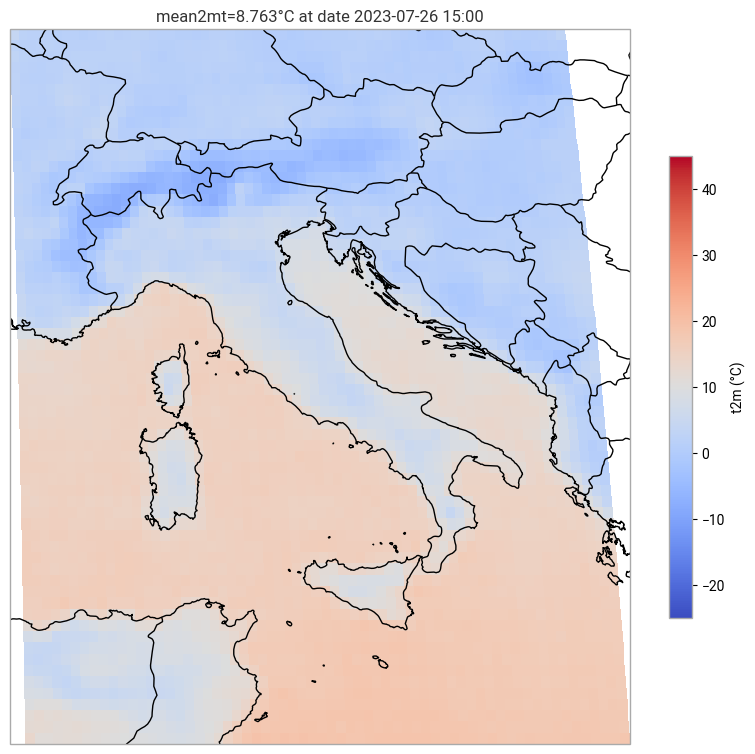

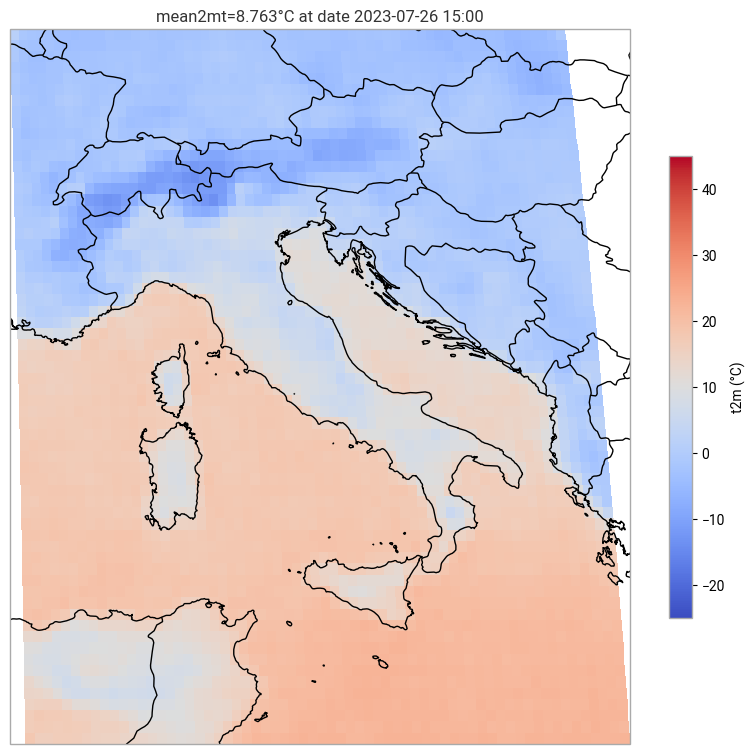

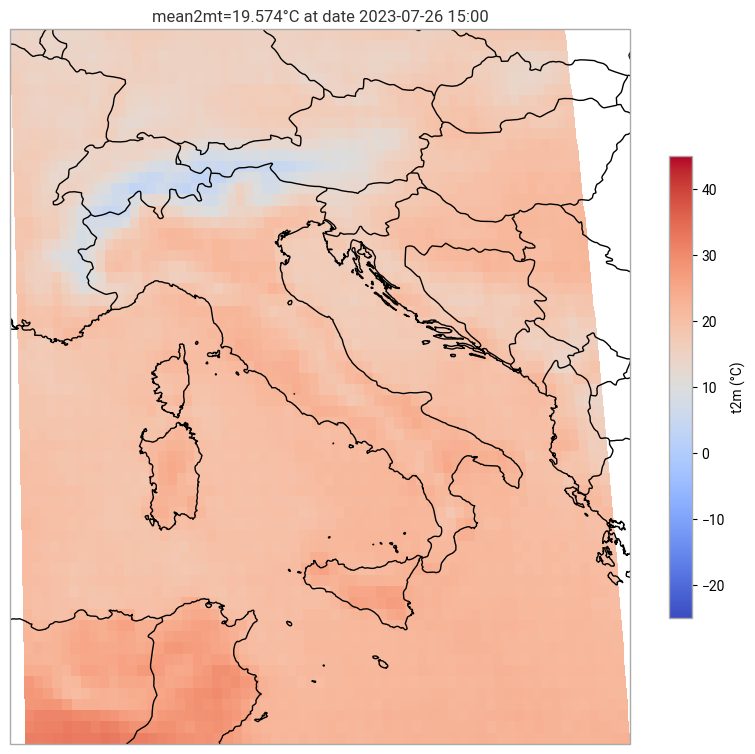

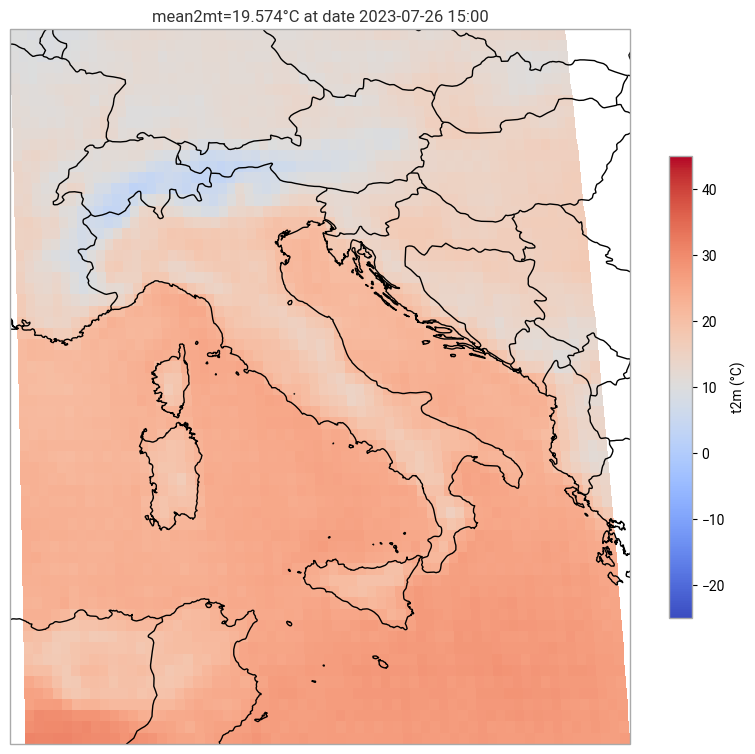

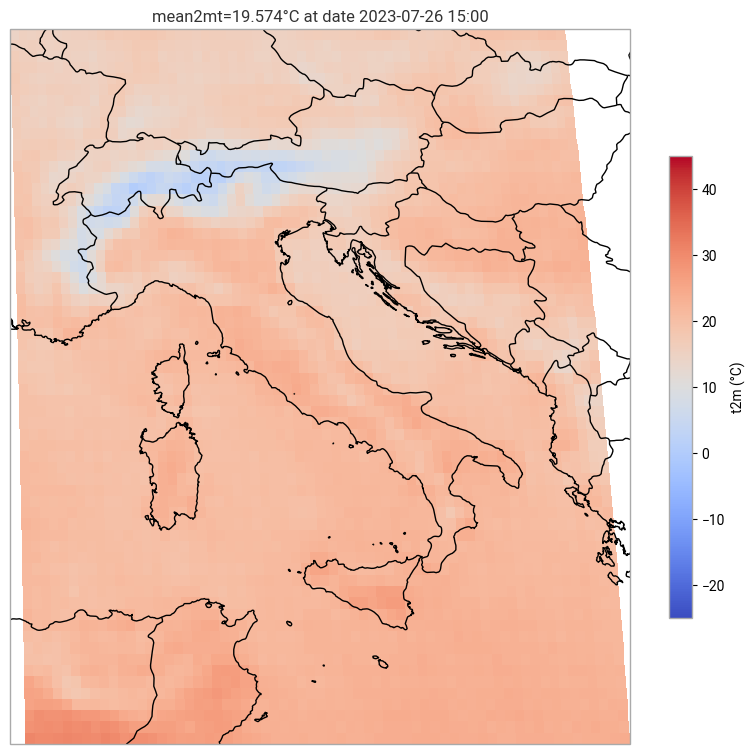

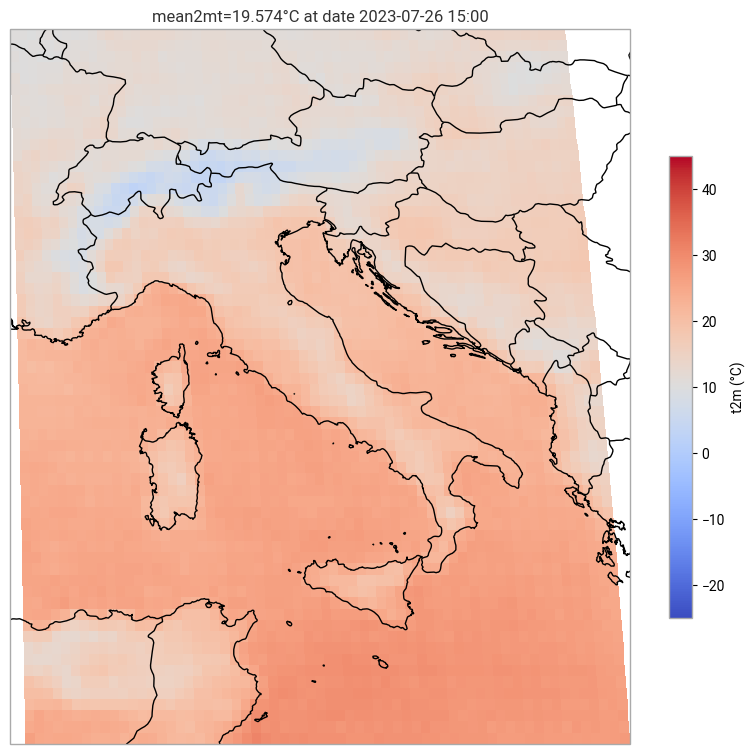

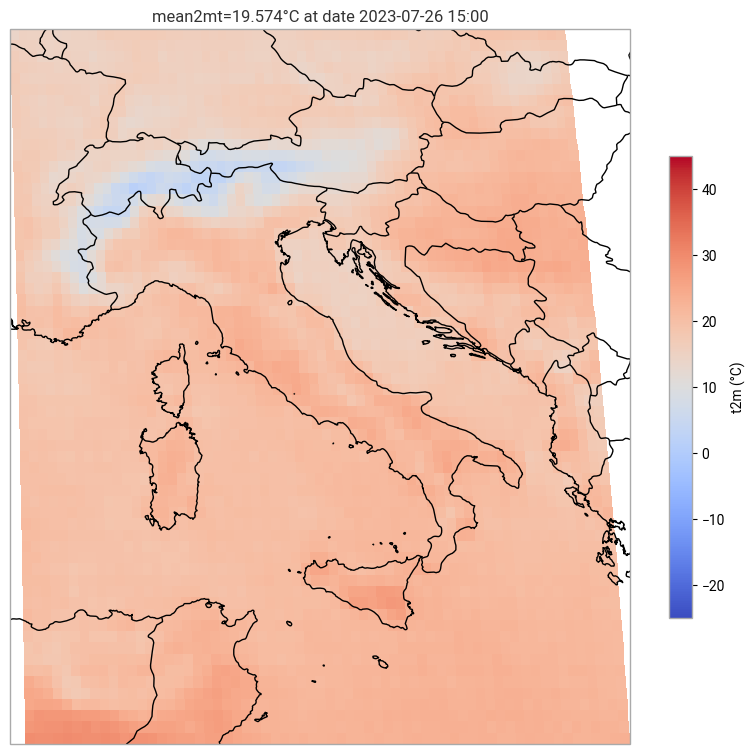

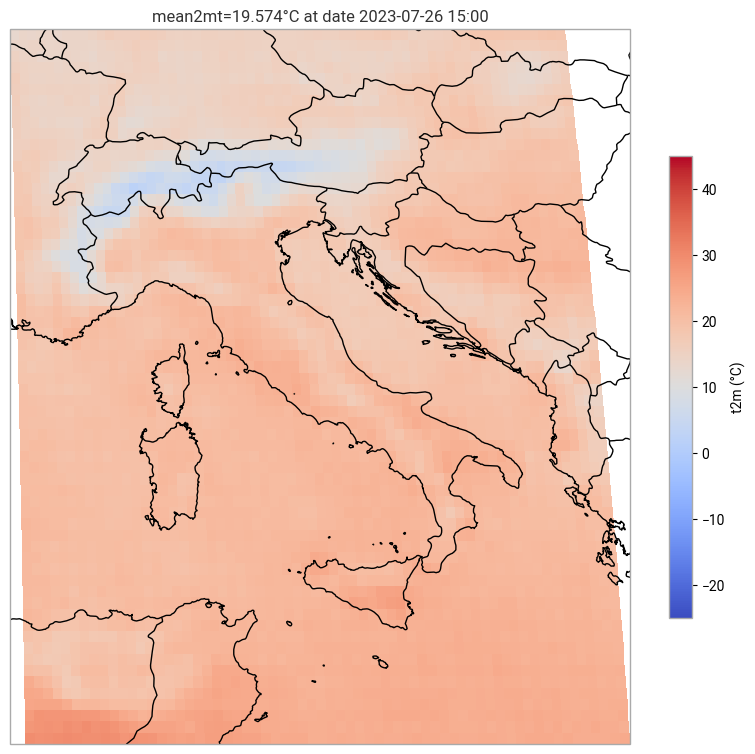

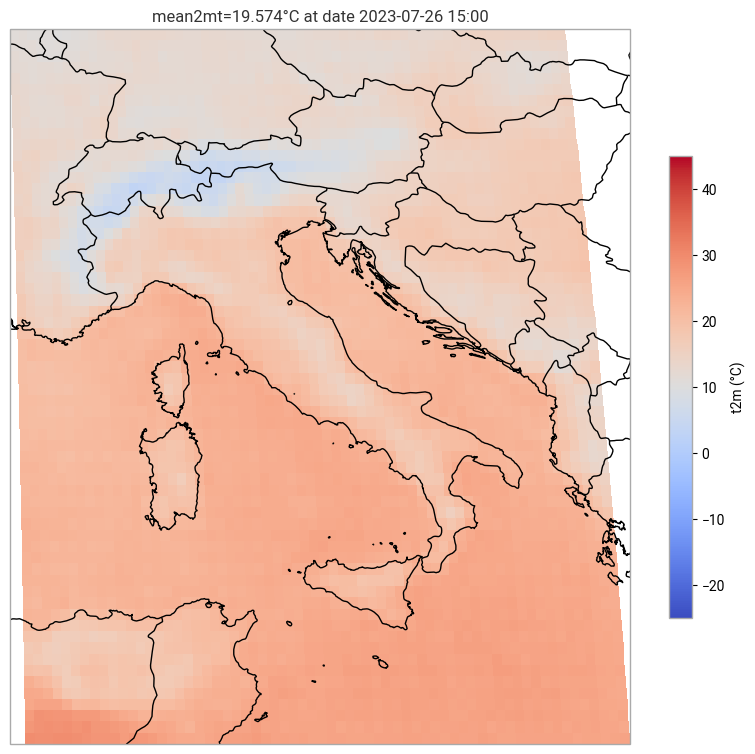

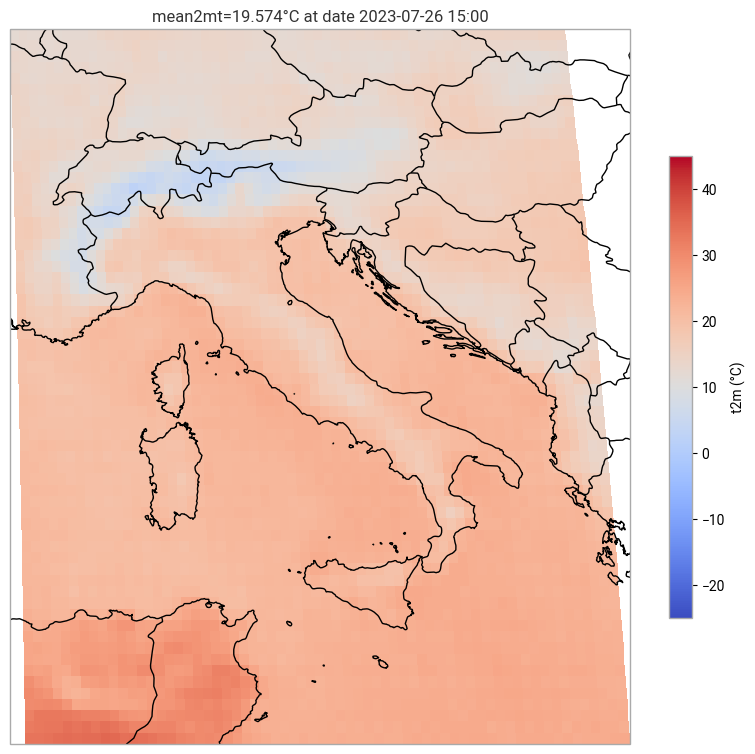

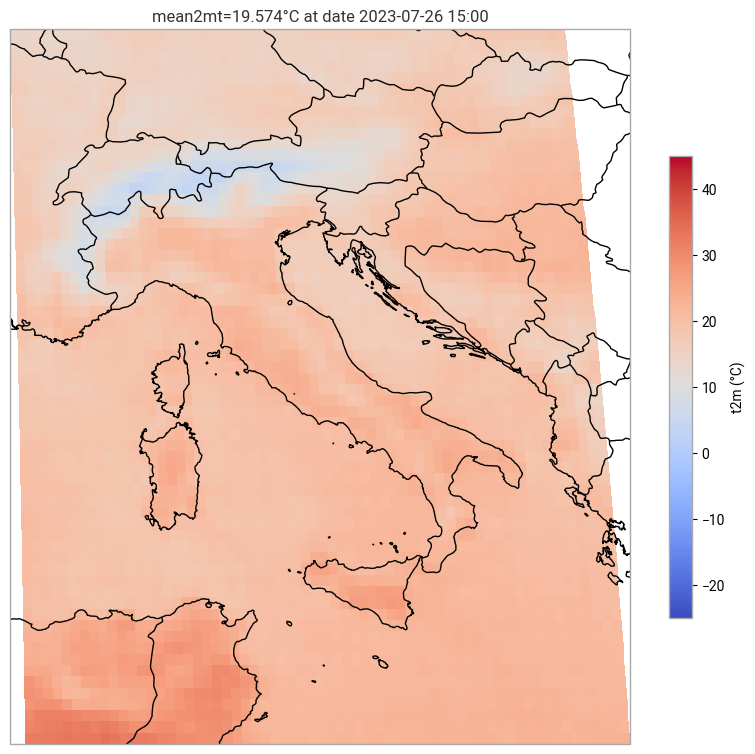

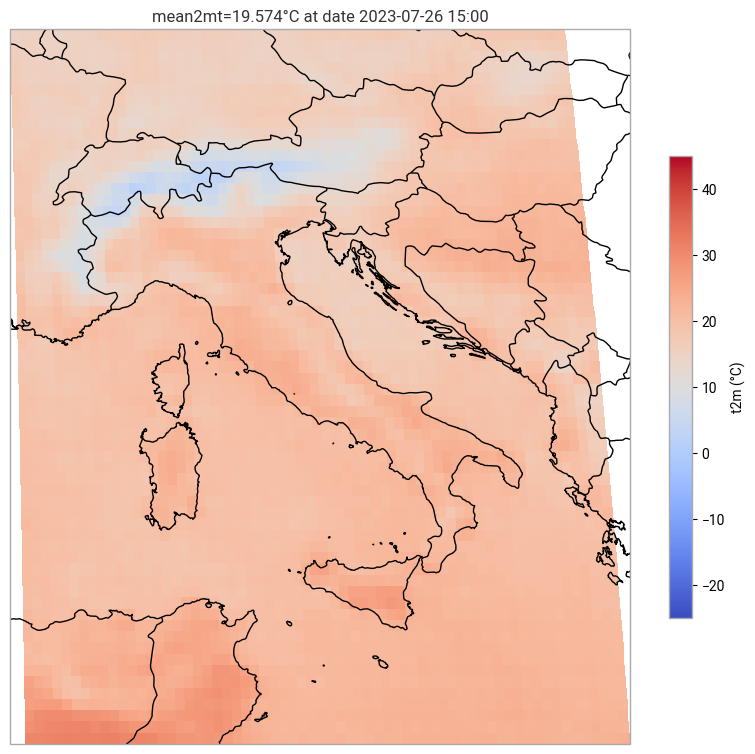

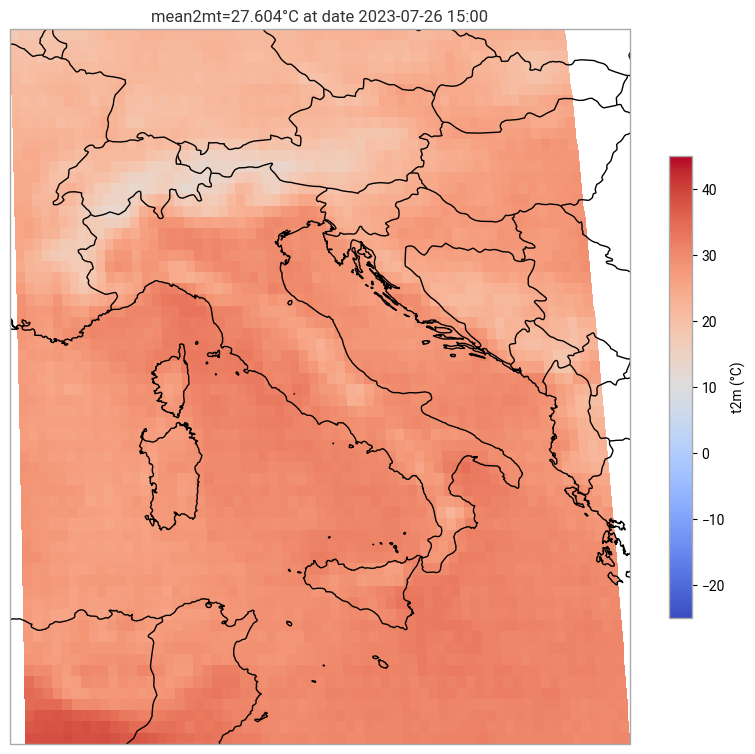

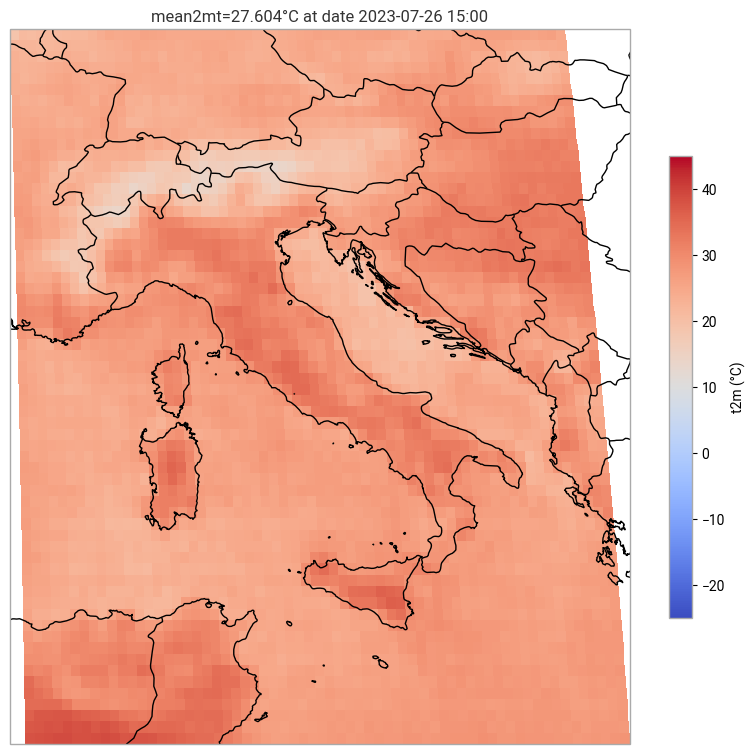

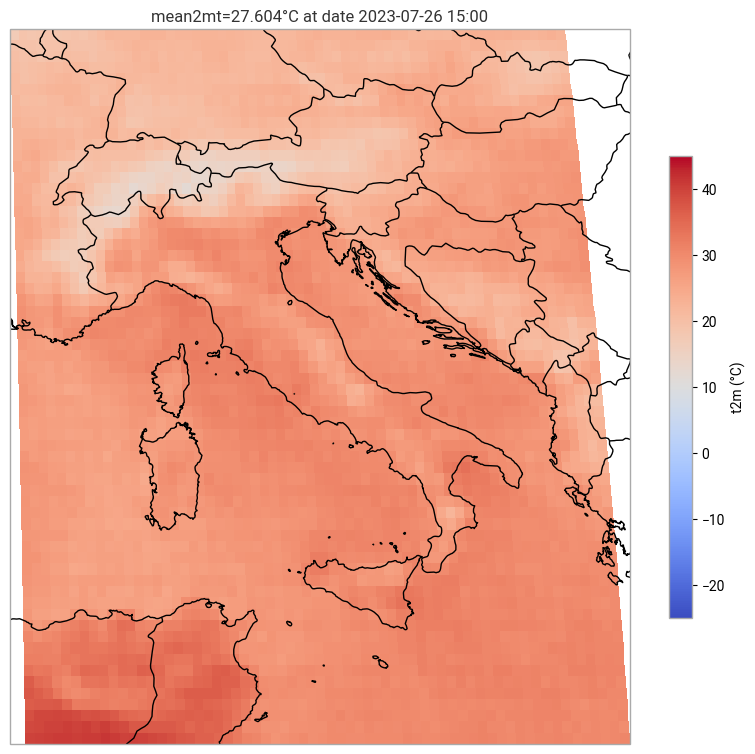

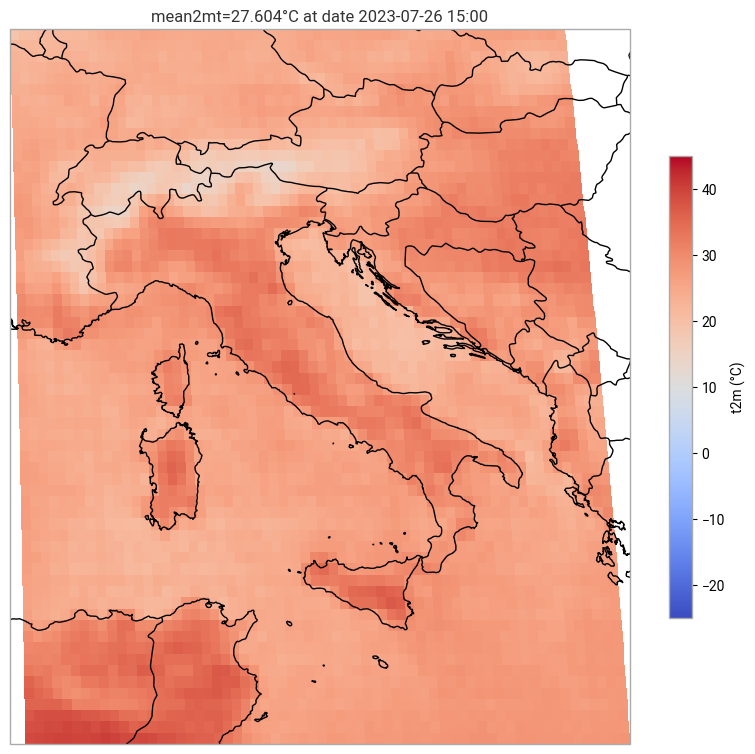

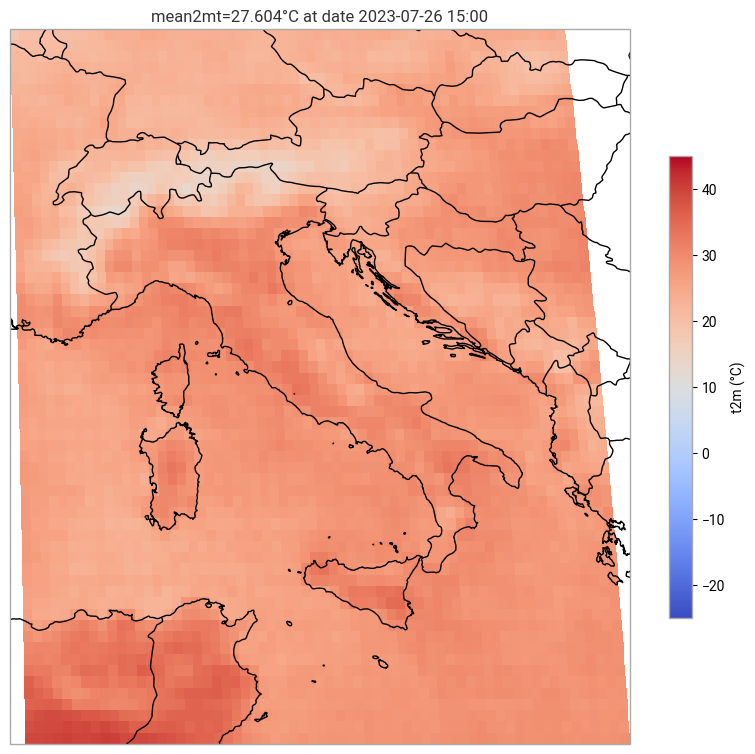

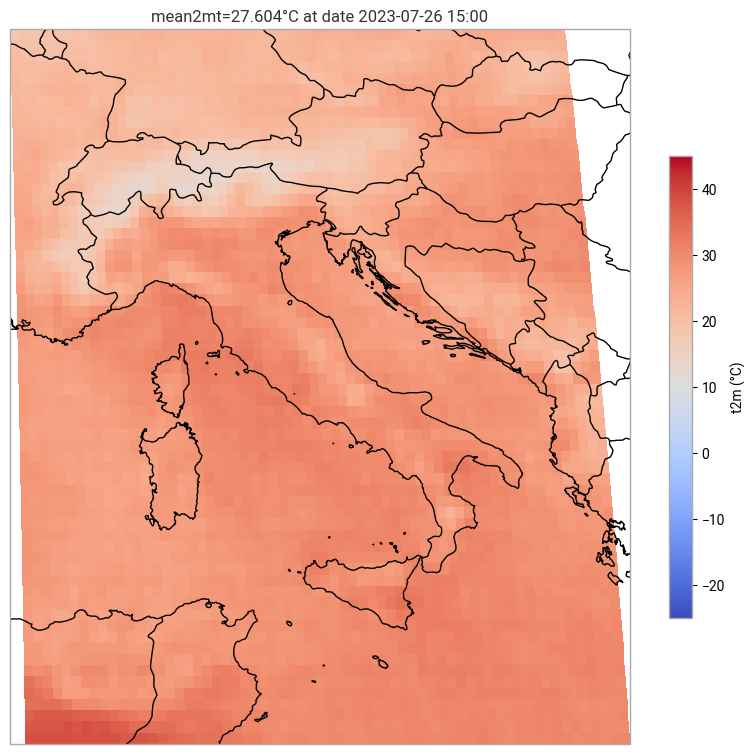

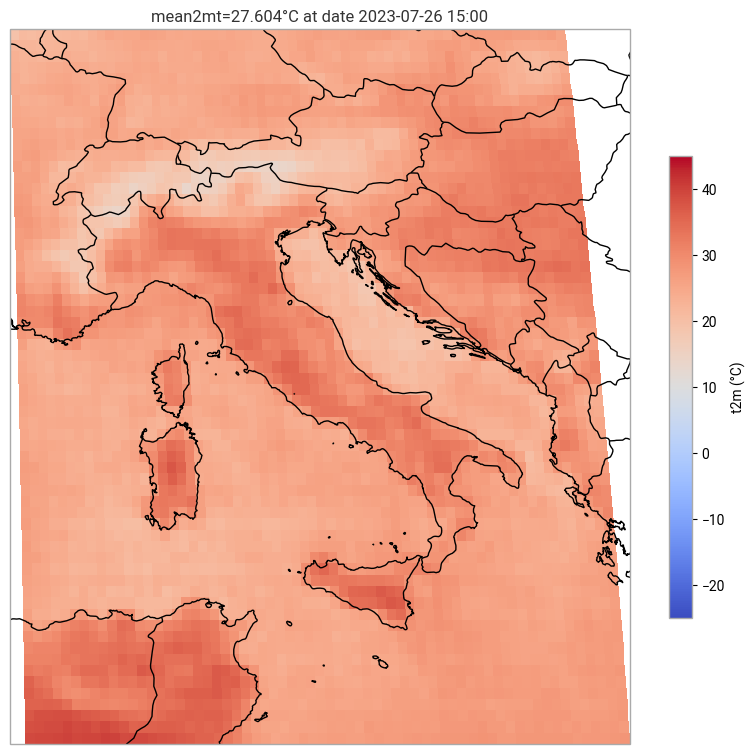

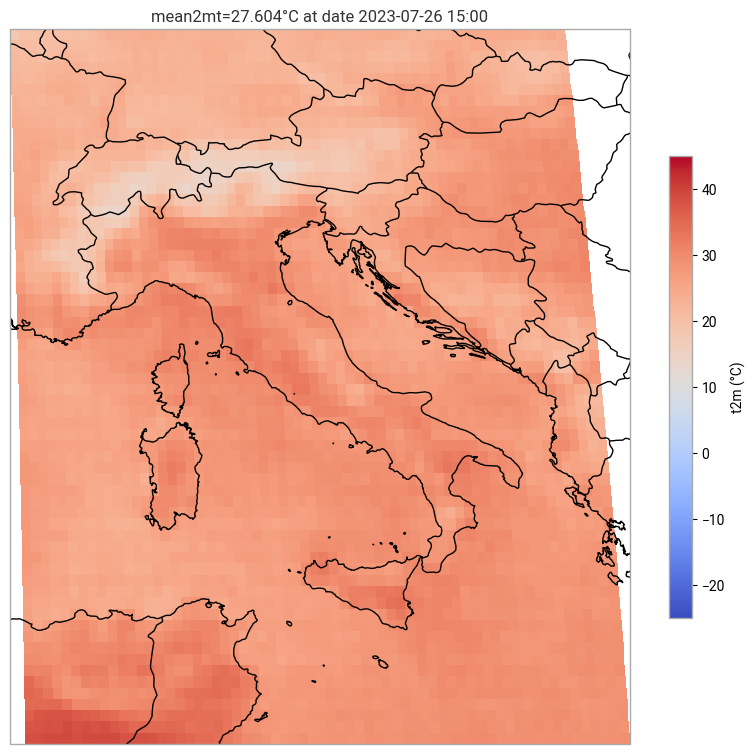

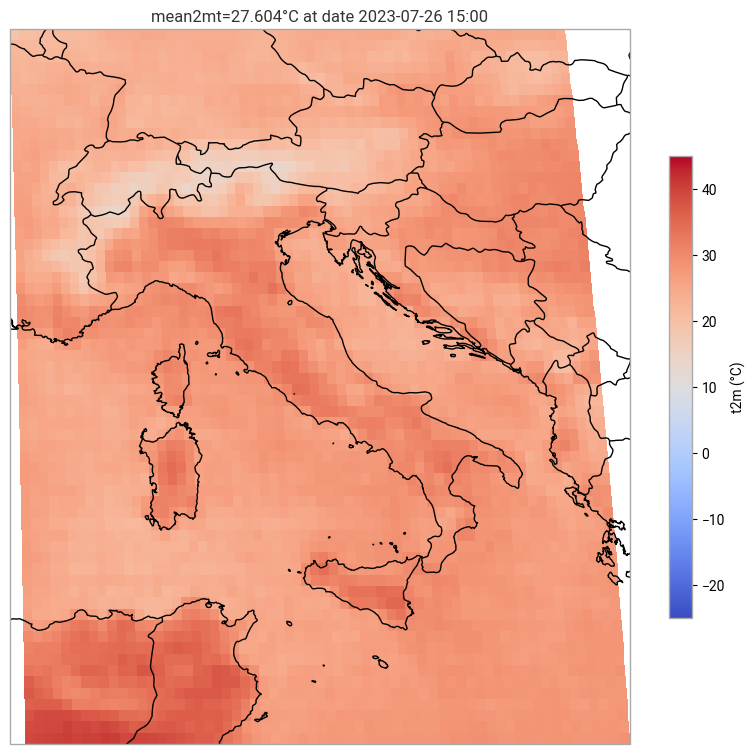

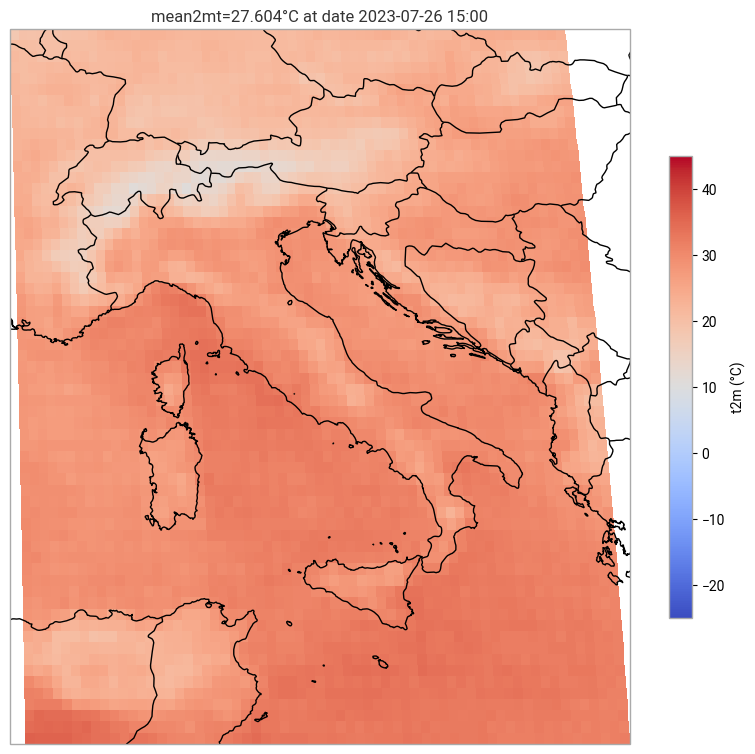

In [ ]:
import matplotlib as mpl

num_plot=10
for d in range(date_size):
  for j in range(num_plot):
    img_to_plot=(generated_imgs.isel(mean2mt=d)[:,:,j]/255*100-50)  #IMG DIFFERENCE TO COMPARE

    # Assuming img0 is your xarray data object
    fig = plt.figure(figsize=(10, 10))

    # Create an axis with a Robinson projection
    ax = plt.axes(projection=ccrs.Robinson())

    # Add coastlines
    ax.coastlines(resolution="10m")

    # Add the shapefile for Italy's boundaries
    # This loads the 'admin_0_boundary' feature (which includes country boundaries)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')

    # You can zoom in further on Italy's boundaries if needed
    #ax.set_extent([-15, 45, 35, 50], crs=ccrs.PlateCarree())  # Adjust lat/lon to zoom in on Italy

    # Plot the temperature data
    plot = img_to_plot.plot(
        cmap=plt.cm.coolwarm, norm = mpl.colors.Normalize(vmin=-25, vmax=45),transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6,"label": "t2m (°C)"}
    )

    # Add a title with the time information
    plt.title(f"mean2mt={'%.3f'%((img_to_plot.mean2mt.values*0.5+0.5)*100-50)}°C at date {pd.Timestamp(cdf.t2m[0].time.values).strftime('%Y-%m-%d %H:%M')}")

    # Show the plot
    plt.show()


In [ ]:
(generated_imgs.isel(mean2mt=d)[:,:,40]/255*100-50)-(generated_imgs.isel(mean2mt=d)[:,:,0]/255*100-50)

<xarray.DataArray 't2m' (lat: 64, lon: 64)> Size: 33kB
array([[-0.08364808, -0.09899065, -0.10018143, ..., -0.15127743,
        -0.14649634, -0.13442694],
       [-0.10210823, -0.10321524, -0.10362812, ..., -0.13909433,
        -0.14535941, -0.14365402],
       [-0.10711072, -0.10096531, -0.10729023, ..., -0.11704987,
        -0.12403301, -0.12929879],
       ...,
       [ 0.06738999,  0.06925695,  0.06820978, ...,  0.05552404,
         0.05594291,  0.05356134],
       [ 0.06128049,  0.06637872,  0.06785673, ...,  0.04747578,
         0.04578833,  0.04460353],
       [ 0.05410587,  0.05567962,  0.05579331, ...,  0.04502839,
         0.04096536,  0.03876331]])
Coordinates:
  * lat      (lat) float64 512B 50.0 49.75 49.5 49.25 ... 35.0 34.75 34.5 34.25
  * lon      (lon) float64 512B 5.0 5.25 5.5 5.75 6.0 ... 20.0 20.25 20.5 20.75
    mean2mt  float64 8B 0.5521